<img src="img/usmlogo.png" style="float:right;height:85px">
<img src="img/dilogo.png" style="float:left;height:90px">
<center>
    <h1> Laboratorio 3 </h1>
    <h2> Profesor: Ricardo Ñanculef </h2>
    <h3> Ayudante: Gabriel Ortega </h3>
    <h4> Renato Bassi Castillo ; 201773521-K ; Malla Nueva </h4>
    <h4> Joaquín Castillo Tapia ; 201773520-1 ; Malla Nueva </h4>
    <center><h4>Julio  2019</h4></center>
</center> 



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 
sns.set()
%matplotlib inline 

## 1. LDA (40p)

Es de mucho interés hoy en día el hecho de poder construir un clasificador que pueda inferir reglas a partir de los datos para poder predecir a futuro, en esta sección trabajará con una versión simplificada del dataset del titanic (data_titanic.csv), la que contiene 3 columnas:

* Age: la edad del pasajero
* Fare: el precio del boleto
* Survived: si sobrevivió a la tragedia o no

(Si, estamos en el ámbito multivariado ahora)

El clasificador, en breves palabras, intenta maximizar $P(Y=survived|X=age,fare)$ asumiendo que los datos ($X$) provienen de una distribución Gaussiana Multivariada. Se espera que usted sea capaz de obtener los máximos verosímiles de los parámetros de esta distribución para poder construir su clasificador **a mano**.

>a) Construya un clasificador LDA que permita distinguir si un pasajero sobrevive o no dado su edad y precio del ticket. *Recomendación: Puede separar una cantidad pequeña de datos para utilizarlos para probar su clasificador, es muy importante que si hace esto, estos datos no sean utilizados en la construcción del clasificador* 

Cualquier uso de las funciones provistas por los lenguajes que implementen LDA implica puntaje 0 en esta sección **sin excepción**.

Esta pregunta es un poco extensa por lo que se recomienda leer bien el material provisto (mas abajo) y los libros guías del curso. No es necesario que responda todo de una, puede ir por partes, es más, esto es recomendable porque así puede ir ganando puntaje y no jugarse todo en un "funciona/no funciona" recuerde explicar bien su razonamiento.

Si se complica mucho intente el caso univariado primero (fare vs survived ó age vs survived), si solamente presenta el univariado podrá optar a solamente 10 puntos del total (siempre y cuando esté bien).

## Desarrollo

Lo primero es extraer los datos a utilizar del archivo entregado:

In [129]:
dataset = pd.read_csv('titanic.csv')
dataset = dataset[pd.notnull(dataset['Age'])]
X1 = dataset.iloc[:, 5].values
X2 = dataset.iloc[:, 9].values
y = dataset.iloc[:, 1].values

LSx=[]
LSy=[]
LS=[]
LMx=[]
LMy=[]
LM=[]
for i in range(len(y)):
    if y[i] == 1:
        LSx.append(X1[i])
        LSy.append(X2[i])
        LS.append([[X1[i],X2[i]]])
    else:
        LMx.append(X1[i])
        LMy.append(X2[i])
        LM.append([[X1[i],X2[i]]])

Con los datos extraidos construimos dos histogramas para observar de mejor manera la relación individual de cada variable.

Histograma de Sobrevivencia según la edad:

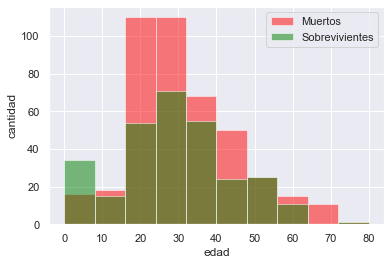

In [174]:
plt.hist(LMx,bins = 10, range = (0,80),color="red",alpha=0.5,label="Muertos")
plt.hist(LSx,bins = 10, range = (0,80),color="green",alpha=0.5,label="Sobrevivientes")
plt.legend(loc='best')
plt.xlabel("edad")
plt.ylabel("cantidad")
plt.show()

Histograma de Sobrevivencia según el precio del boleto:

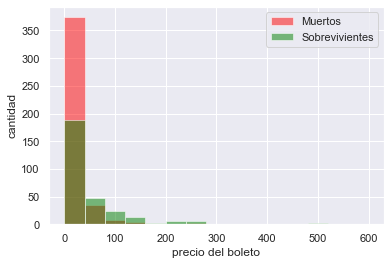

In [175]:
plt.hist(LMy,bins = 15, range = (0,600),color="red",alpha=0.5,label="Muertos")
plt.hist(LSy,bins = 15, range = (0,600),color="green",alpha=0.5,label="Sobrevivientes")
plt.legend(loc='best')
plt.xlabel("precio del boleto")
plt.ylabel("cantidad")
plt.show()

Separamos los datos en dos, para entrenamiento y posterior testeo.

In [177]:
LS_train = LS[:int(len(LS)/2)]
LM_train = LM[:int(len(LM)/2)]
LS_test = LS[int(len(LS)/2):]
LM_test = LS[int(len(LM)/2):]

Calculamos los vectores de media aritmética para sobrevivientes y muertos:

In [196]:
mu11 = np.average(LSx[:int(len(LS)/2)])
mu12 = np.average(LSy[:int(len(LS)/2)])
mu01 = np.average(LMx[:int(len(LS)/2)])
mu02 = np.average(LMy[:int(len(LS)/2)])

mu1 = [[mu11,mu12]]
mu0 = [[mu01,mu02]]

Vector de media aritmética de sobreviviencia:

In [193]:
print(mu1)

[[26.77413793103448, 48.47614896551725]]


Vector de media aritmética de muerte:

In [197]:
print(mu0)

[[30.56896551724138, 25.34649379310345]]


A continuación se calculan las matrices de covarianza, con clases y entre clases. Para ello se siguen las siguientes fórmulas:

Para la covarianza conclases:


\begin{aligned}
S_w = {\sum_{i=1}^{c}}{S_i}
\end{aligned}

donde:

\begin{aligned}
S_i = {\sum_{x \epsilon D_i}^{n}}{(x-m_i)}{(x-m_i)}^{T}
\end{aligned}

Para la covarianza entre clases:

\begin{aligned}
S_b = {(m_2-m_1)}{(m_2-m_1)}^{T}
\end{aligned}

In [156]:
def Si(L,mu):
    mu=np.array(mu)
    r = [[0.0,0.0],[0.0,0.0]]
    r = np.array(r)
    for i in L:
        t = np.array(i)
        x = t - mu
        xT = x.transpose()
        r+=(x*xT)
    return r

In [157]:
def Sb(mu1,mu2):
    m1 = np.array(mu1)
    m2= np.array(mu2)
    x = m2-m1
    xT = x.transpose()
    return x*xT 

Matriz de covarianza con clases:

In [158]:
Sw = Si(LS,mu1)+Si(LM,mu0)
print(Sw)

[[ 149559.44836245   64005.45388878]
 [  64005.45388878 1853082.01728879]]


Matriz de covarianza entre clases:

In [159]:
Sb = Sb(mu1,mu0)
print(Sb)

[[  5.20975873 -65.91316103]
 [-65.91316103 833.92437602]]


Luego se buscan los vectores y valores propios para dar solución a la siguiente ecuación:

\begin{aligned}
A = S_w^{-1}S_b
\end{aligned}
    
Donde $Av=\lambda v$ , $\lambda$ son los valores propios y $v$ son los vectores propios.

In [ ]:
vr_pro, vc_pro = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

for i in range(len(eig_vals)):
    vc_pro_sc = vc_pro[:,i].reshape(2,1)
    print('\nVector Propio {}: \n{}'.format(i+1,  vc_pro_sc.real))
    print('Valor Propio {:}: {:.2e}'.format(i+1, vr_pro[i].real))

Valores propios ordenados de Mayor a Menor:

In [165]:
pr_pro = [(np.abs(vr_pro[i]), vc_pro[:,i]) for i in range(len(vr_pro))]
pr_pro = sorted(pr_pro, key=lambda k: k[0], reverse=True)
for i in pr_pro:
    print(i[0])

0.0005230301710079941
0.0


Se calcula la exactitud de cada valor propio encontrado:

In [200]:
eigv_sum = sum(vr_pro)
for i,j in enumerate(pr_pro):
    print('Valor propio {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))


Valor propio 1: 100.00%
Valor propio 2: 0.00%


Finalmente, con el vector propio 1 se obtiene la matriz de vector propio, y así reducir la dimension de los datos:

In [168]:
W = np.hstack((pr_pro[0][1]))
print(W.real)

[ 0.80590827 -0.59204042]


Utilizando los datos de testeo y la matriz W encontrada se calcula la transformación de las muestras a una dimensón:

In [172]:
LS_test = np.array(LS_test)
LM_test = np.array(LM_test)
LS_lda = LS1.dot(W)
LM_lda = LM1.dot(W)

Finalmente se gráfican los resultados:

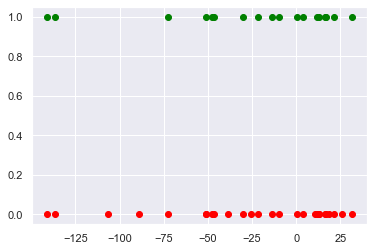

In [173]:
plt.plot(LS_lda, np.ones((len(LS_lda),1)), 'ro', color = 'green')
plt.plot(LM_lda, np.zeros((len(LM_lda),1)),'ro',color='red')
plt.show()

En conclusión, según los resultados, podemos inferir que los datos de edad y precio del boleto no son los adecuados para predecir la supervivencia de los pasajeros del Titanic. Ya que, no es posible agrupar a los sobrevivientes en un rango de datos que excluya a los muertos.

Otra posibilidad es que los datos de entrenamiento utilizados no fueron los adecuados, y esto desencadeno un mal resultado con los datos de prueba.

## 2. Teorema de la Función Inversa (10p)

El teorema de la función inversa permite generar variables aleatorias continuas con una función de distribución $F(x)$ a partir de la inversa $F^{-1}(x)$. Donde los valores generados en la función inversa están regidos por una distribución uniforme $u \sim U(0,1)$. 

En esta sección se trabajará con la distribución Weibull, cuya función de densidad de probabilidad está dada por:

\begin{aligned}
Weibull(\alpha,\beta) = \frac{\alpha}{\beta^{\alpha}}x^{\alpha -1}\cdot exp \left( \frac{-x}{\beta}\right)^{\alpha}
\end{aligned}






Para trabajar el teorema de la función inversa siga los siguientes pasos:

1. Identificar la función que defina a la variable aleatoria.

**R.-** La variable aleatoria que identifica a la función sigue una distribución _Weibull_.

$$X \sim Weibull(\alpha,\beta)$$

2. De dicha función calcular la función de densidad acumulada. Explique en breves palabras como obtenerla y si es invertible o no (Lo de invertible hace referencia a esta función de densidad acumulada Weibull en particular y no olvide mencionar cual es la función de densidad acumulada Weibull).


**R.-** Para obtener la función de densidad  acumulada integramos la función de probabilidad desde el $-\infty$ hasta un $x$ genérico:

$$F(x) = \int \limits_{-\infty}^{x} \frac{\alpha}{\beta^{\alpha}}x^{\alpha -1}\cdot exp \left( \frac{-x}{\beta}\right)^{\alpha} \cdot dx = 1- exp (-\left( \frac{x}{\beta}\right)^{\alpha})$$

La función es invertible ya que es continua y diferenciable en todo su dominio, además $F'(x) \neq 0$ $\forall$ $ x $ $\epsilon$ $ \mathbb{R}$  

3. De la función de densidad acumulada despejar la variable X. La distribución Weibull a trabajar tiene parámetros $\alpha = 10$ y $\beta = 3$


**R.-** Al despejar $x$ obtenemos:

$$x = {\beta}(- ln(1-F))^{\frac 1\alpha}$$

4. Generar 10000 valores que siguen la distribución $u \sim U(0,1)$ y utilícelos como argumento en la función inversa encontrada


**R.-** Para generar los valores se utiliza la librería random de numpy, y se evaluan en la función encontrada.

**iweib(int F, float b, float a)**

Función inversa encontrada anteriormente, **_F_** es el resultado de la función de distribución acumulada, **_b_** y **_a_** son $\alpha$ y $\beta$ respectivamente. 

In [14]:
def iweib(F,b,a):
    return b*(-np.log(1-F))**(1/a)

Se genrarn los datos solicitados:

In [15]:
np.random.seed(2017)
datos = np.random.uniform(0,1,10000)
inversa=[]

for i in datos:
    inversa.append(iweib(i,3,10))

Se construye un histogrma con los datos:

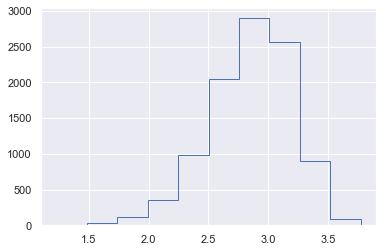

In [16]:
count, bins = np.histogram(inversa)
plt.hist(bins[:-1],bins, weights=count, histtype='step')
plt.show()

5. Genere una distribución weibull de tamaño 10000 con los mismos $\alpha$ y $\beta$ que la trabajada. Y haga un gráfico de la densidad de dichos valores. 


se definen los $\alpha$ y $\beta$ correspondioentes:

In [17]:
a = 10
b = 3

Se generan los datos y se construye el histograma que representa a la función:

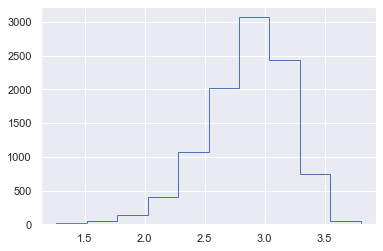

In [18]:
np.random.seed(2015)
x = np.random.weibull(a, 10000)
plt.hist(x*b, histtype='step')
plt.show()

6. Concluya respecto a lo que observa en ambas gráficas.

**R.-** Para un mejor análisis se construye un gráfico con ambos histogramas.

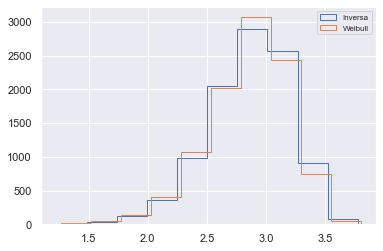

In [19]:
plt.hist(bins[:-1], bins, weights=count, histtype='step', label = 'Inversa')
plt.hist(x*b, histtype='step', label = 'Weibull')
plt.legend(loc='best', prop={'size': 8})
plt.show()

En base a lo observado en el gráfico presente, se puede decir que, de manera empírica, se  cumple el Teorema de la función Inversa.  Ya que al evaluar los datos de una diostribución uniforme en la inversa de la función acumulada de Weibull resulta una distribución de Weibull. Se puede decir entonces, que hay una relación entre los parámetros de la distribución uniforme y los parámetros de la distribución Weibull.

## 3. Teorema del Límite Central (30p)

El teorema del límite central es uno de los postulados más importantes de estadística. En esta sección se procederá a comprobarlo en su forma clásica. 

Sea $x_{1},x_{2},....,x_{n}$ una muestra aleatoria de tamaño $n$ IID extraidas de una distribución con valor esperado $\mu$ y varianza finita $\sigma^{2}$. Si calculamos la media muestral: 

$$ \bar{X}_{n} = \frac{\sum x_{i}}{n}$$

Y repetimos este proceso una gran cantidad de veces $(P)$ tendremos una distribución de las medias de las muestras (*Sample mean distribution*). El TLC establece que, si el número de repeticiones es lo suficientemente grande: 

$$ \bar{X} \sim N\left(\mu,\sqrt{\frac{\sigma^{2}}{n}}\right)$$ 

En esta sección se trabajará con la siguiente distribución y se demostrará lo que enuncia el TLC.

| Valor | Probabilidad |
|:-----:|:------------:|
|   1   |      0.1     |
|   2   |      0.2     |
|   5   |     0.05     |
|   6   |     0.05     |
|   7   |      0.2     |
|   9   |     0.10     |
|   10  |     0.05     |
|   11  |     0.2      |
|   12  |     0.05     |

>a) Determine el valor esperado y la varianza **TEÓRICOS**

**R.-** La esperanza matemática, o tambien llamada valor esperado, es el resultado promedio de un evento probabilístico. Es equivalente a la suma de cada posible resultado multiplicado con su respectiva probabilidad, es decir:

$$E[X]=\sum_{i=1}^{n}x_{i} \cdot P(x_{i})$$

En cuanto a la varianza, la cual es el promedio de las distancias entre cada dato y su valor esperado, se puede calcular mediante la siguiente fórmula:

$$V[X]=E[X^{2}]-E[X]^{2}$$

Desarrollo
-----------

Se presentan dos listas, con los datos de la tabla, para futuros calculos:

In [20]:
v = [1,2,5,6,7,9,10,11,12]  # Valores
p = [0.1,0.2,0.05,0.05,0.2,0.10,0.05,0.2,0.05] # Probabilidades

El Valor Esperado Teórico es:

In [21]:
print(sum(map((lambda x,y:x*y),v,p)))

6.65


La Varianza Teórica es igual a:

In [22]:
print(sum(map((lambda x,y:(x**2)*y),v,p))-(sum(map((lambda x,y:x*y),v,p))**2))

14.027500000000003


_______________
>b) Con $P = 10,1000$ calcule la media de muestras de tamaño : $n \in[2,10,30,100,1000]$ compare los resultados obtenidos para los dos $P$ dados. Presente los datos en una tabla ordenada con columnas: $n,\;P=10,\;P=1000$ Comente, ¿qué parece influir mas, la cantidad de repeticiones, el tamaño de la muestra o ambas?

**R.-** Para la simulación del experimento se utilizarán dos funciones, una que calcule la Media de los datos dados, y otra que genere una muestra de datos aleatorios dada las probabilidades antes entregadas. 

**Media( list L )**

Función que calcula la media aritmética de la lista de datos **L**.

In [23]:
def Media(L):
    return sum(L)/len(L)

**elegir( list v, list p, int n, int P)**

Función que genera una lista de largo **_P_**, en donde cada elemento es la media aritmética de una lista de largo **_n_** generada a partir de los valores de la lista **_v_** en base a la probabilidad señalada por la lista **_p_**.

In [24]:
def elegir(v,p,n,P):
    np.random.seed(2017)
    r=[]
    for i in range(P):
        l = np.random.choice(v,size=n,p=p)
        m = Media(l)
        r.append(m)
    return r

____________
Desarrollo
---------

P = 10
-------

Para **n = 2** la media es:

In [25]:
P10_N2 = elegir(v,p,2,10)
print(Media(P10_N2))

5.3


Para **n = 10** la media es:

In [26]:
P10_N10 = elegir(v,p,10,10)
print(Media(P10_N10))

6.24


Para **n = 30** la media es:

In [27]:
P10_N30 = elegir(v,p,30,10)
print(Media(P10_N30))

6.24


Para **n = 100** la media es:

In [28]:
P10_N100 = elegir(v,p,100,10)
print(Media(P10_N100))

6.604999999999999


Para **n = 1000** la media es:

In [29]:
P10_N1000 = elegir(v,p,1000,10)
print(Media(P10_N1000))

6.625100000000001


____________
P = 1000
-------

Para **n = 2** la media es:

In [30]:
P1000_N2 = elegir(v,p,2,1000)
print(Media(P1000_N2))

6.656


Para **n = 10** la media es:

In [31]:
P1000_N10 = elegir(v,p,10,1000)
print(Media(P1000_N10))

6.625099999999996


Para **n = 30** la media es:

In [32]:
P1000_N30 = elegir(v,p,30,1000)
print(Media(P1000_N30))

6.60766666666667


Para **n = 100** la media es:

In [33]:
P1000_N100 = elegir(v,p,100,1000)
print(Media(P1000_N100))

6.645459999999995


Para **n = 1000** la media es:

In [34]:
P1000_N1000 = elegir(v,p,1000,1000)
print(Media(P1000_N1000))

6.649298000000003


-------------------
En resumen los resultados son:


|  $$n$$ |  $$P=10$$ | $$P=1000$$ |
|:------:|:---------:|:----------:|
|   2    |  5.300    |  6.656     |
|  10    |  6.240    |  6.625     |
|  30    |  6.240    |  6.608     |
|  100   |  6.605    |  6.645     |
|  1000  |  6.625    |  6.645     |


**Análisis y Respuesta**

A simple vista podemos darnos cuenta que los resultados para un **P = 10** son más variados que los obtenidos para **P = 1000**. Además, según el valor esperado calculado en el incisoo a) (*6.5*), los datos obtenidos para  un **P = 1000** son más cercanos y más precisos para los diferentes **_n_** evaluados, incluso para **n = 2** en donde el resultado obtenido para **P = 10** es evidentemente diferente al valor teórico, y no así el valor encontrado con un **P = 1000** el cual es indudablemente cercano al valor correcto. Aun así, los resultados se acercan al valor teórico a medida que aumenta el **_n_**, esto ya que con una muestra más grande es más apreciable la probabilidad de cada valor, y por ende se obtiene una media más representativa.

En base a lo comentado y lo observado en los resultados, es posible afirmar que ambas variables, la cantidad de repeticiones (**_P_**) y el tamaño de la muestra (**_n_**), influyen en el resultado. Pero, indudablemente la cantidad de repeticiones influye de mayor manera en el experimento, ya que para un gran número de repeticiones es posible acercarse al valor teórico con muestras muy pequeñas.

____________
>c) Con lo obtenido en b) haga un histograma para las muestras de tamaño 2, 30 y 1000 de P = 1000. Comente lo que observa y concluya. ¿Se cumple lo que enuncia el teorema del límite central?

**R.-** Para la construcción de los histogramas se utilizarán los mismos datos usados anteriormente para el calculo de la media.

Desarrollo
-------

Histograma para **P = 1000** y **n = 2**

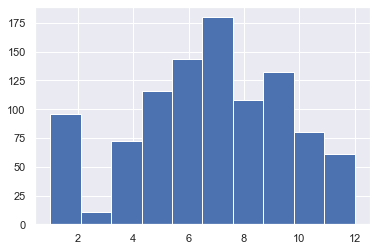

In [35]:
plt.hist(P1000_N2)
plt.show()

_________
Histograma para **P = 1000** y **n = 30**

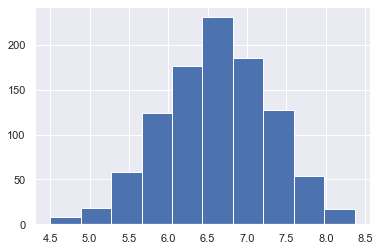

In [36]:
plt.hist(P1000_N30)
plt.show()

_________
Histograma para **P = 1000** y **n = 1000**

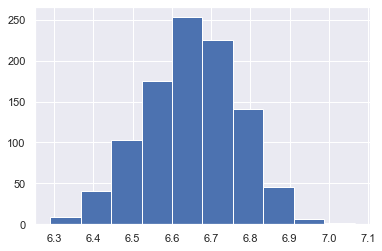

In [37]:
plt.hist(P1000_N1000)
plt.show()

____________
**Análisis y Respuesta**

A medida que aumenta el tamaño de la muestra se evidencia una dismunución en la amplitud de los datos. Pues en un principio se observa una amplitud de largo 12, y finalmente se presenta una amplitud de largo aproximado a 1.1, evidentemente menor a su valor inicial. Además, a medida que aumenta el tamaño de la muestra también se presenta una mejor aproximación a una distribución normal con $\mu$ igual a *6.5*, y es evidente que también disminuye la dispersión de los datos, concentrandose cada vez más cerca de la media. 

Por lo tanto, es posible decir que sí se cumple lo estipulado en el **_Teorema del Límite Central_**, pues para un gran numero de repeticiones los datos obtenidos se comportan como una distribución normal con $\mu$ equivalente a la esperanza $(E)$ de los datos estudiados.

______________
## 4. Ley de los Grande Números (20p)

En estadística, la ley de los grandes números engloba teoremas que describen el comportamiento del promedio de una distribución de variables aleatorias. La ley de los grandes números dice que, en pocas palabras, a medida que se aumenta el tamaño muestral el promedio de la distribución de variables aleatorias converge al promedio de la población completa.

Un estudio realizado en el casino de la universidad MSU, indica que el tiempo de espera en la cola del casino para obtener su almuerzo puede modelarse como una distribución Exponencial con parámetro: $\lambda = 0.1$

>a) **Utilizando las funciones provistas por los lenguajes** calcule la probabilida **teórica** de que un alumno espere menos de 10 minutos, exactamente 20 minutos y más de 50 minutos.

**R.-** Para el desarrollo de la respuesta se utilizará la librearía *SciPy* la cual proporciona varios métodos para manejar distribuciones de probabilidad. 

En este caso importaremos la distribucion exponencial (*stats.expon*).

Desarrollo
---------------------

In [38]:
from scipy.stats import expon as ex

En la libreria utlizada se genera la distribución a partir del parámetro *scale* el cual cooresponde  a:

$$scale = \frac{1}{\lambda}$$

Por lo tanto, para generar la distribucón pedida se hace lo siguiente:

In [39]:
lamb = 0.1   # Asiganación del valor entregado
scale = 1/lamb    # lambda = 0.1 -> scale = 1/lambda
x = np.linspace(ex.ppf(0.01,scale = scale),ex.ppf(0.99,scale=scale),100)  # se generan 100 datos que sigan una distr. exp
fdp = ex.pdf(x,scale=scale)  # función de probabilidad con los datos generoados y el scale indicado

Se gráfica el resultado obtenido a partir de los 100 datos generados. En donde la variable aleatoria $X$ representa la cantidad de minutos que espera un alumno en la fila.

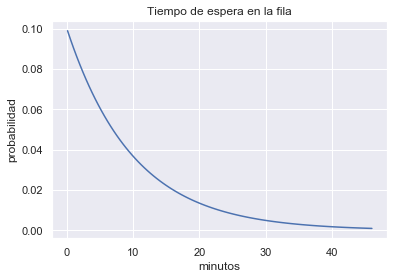

In [40]:
plt.plot(x, fdp)
plt.title('Tiempo de espera en la fila')
plt.ylabel('probabilidad')
plt.xlabel('minutos')
plt.show()

Para el calculo de las probabilidades requeridas se utiliza la densidad acumulada de probabilidad, la cual se define como:

$$F(x) = P(X\leq x) = \int \limits_{-\infty}^{x} fdp(X) \cdot dX$$

Por lo tanto, la probabiliudad de que el alumno espere menos de 10 minutos esta dada por $F(10)$.

Utilizando el método porporcionado por la librería, el resultado es:

In [41]:
print(ex.cdf(10,scale=scale))

0.6321205588285577


La probabilidad de que el alumno espere exactamente 20 minutos es de *0*, ya que está dada por $F(20) - F(20)$.

Utilizando el método porporcionado por la librería, se comprueba el resultado:

In [42]:
print(ex.cdf(20,scale=scale)-ex.cdf(20,scale=scale))

0.0


La probabilidad de que el alumno espere más de 50 minutos esta dada por $1 - F(50)$.

Utilizando el método porporcionado por la librería, el resultado es:

In [43]:
print(1-ex.cdf(50,scale=scale))

0.006737946999085476


Estas tres probabilidades mostradas corresponden a la probabilidad Teórica de cada caso

___________
>b) Ahora genere 3 muestras de dicha distribución exponencial, con tamaños n = 5, 100, 300, 10000. Para cada una de estas muestras determine las mismas probabilidades calculadas en a) de manera empírica, comente sus resultados.

**R.-** Para generar las muestras solicitadas se utilizan los métodos entrgados por la librería antes señalada, y para obtener las probabilidades se crea una función que calcula la densidad de probabilidad.

Desarrollo
-----------------

**FDP(float X, list L)**

Función que recibe una lista **_L_**, ordena los datos de menor a mayor y luego suma a un contador por cada elemento menor **_X_**; Retorna el couciente entre el contador y la cantidad total de datos.

In [44]:
# FDP funcion de distribucion o probabilidad acumulada
def FDP(X,L):
    L.sort()
    P=0
    for i in L:
        if i <= X:
            P+=1
        else:
            return P/len(L)
    return P/len(L)

**fdp(float X, list L)**

Función que calcula la probabilidad de obtener en **_X_** en la lista **_L_**.

In [45]:
def fdp(X,L):
    P = L.count(X)
    return P/len(L)

______
### n = 5

Se generan los datos y se muestra un histograma para evidenciar gráficamente los resultados.

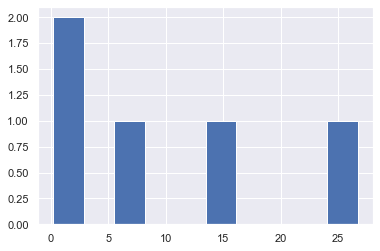

In [46]:
n1 = ex.rvs(size=5,scale=scale,random_state=2017) # 5 valores random de una dist. exp. y una semilla específica.
plt.hist(n1)
plt.show()

Si de la población se estudia una muestra de 5 estudiantes, los resultados de las probabilidades es la siguiente:

$P(X\leq 10) = F(10)$

In [47]:
print(FDP(10,list(n1)))

0.6


$P(X = 20)$

In [48]:
# P(X = 20):
print(fdp(20,list(n1)))

0.0


$P(X\geq 50) = 1 - F(50)$ 

In [49]:
# P(X > 50):
print(1-FDP(50,list(n1)))

0.0


___
### n = 100

Se generan los datos y se muestra un histograma para evidenciar gráficamente los resultados.

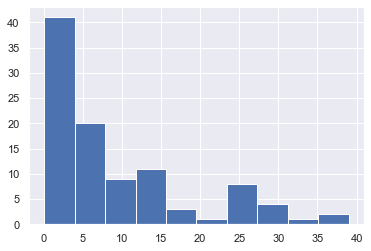

In [50]:
n2 = ex.rvs(size=100,scale=scale,random_state=2017)
plt.hist(n2)
plt.show()

Si de la población se estudia una muestra de 100 estudiantes, los resultados de las probabilidades es la siguiente:

$P(X\leq 10) = F(10)$

In [51]:
# P(X < 10):
print(FDP(10,list(n2)))

0.67


$P(X = 20)$

In [52]:
# P(X = 20):
print(fdp(20,list(n2)))

0.0


$P(X\geq 50) = 1 - F(50)$ 

In [53]:
# P(X > 50):
print(1-FDP(50,list(n2)))

0.0


___
### n = 300

Se generan los datos y se muestra un histograma para evidenciar los resultados.

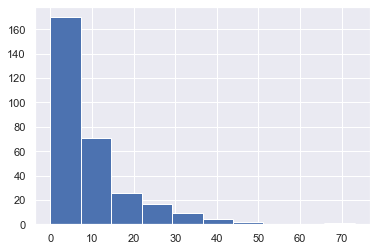

In [54]:
n3 = ex.rvs(size=300,scale=scale,random_state=2017)
plt.hist(n3)
plt.show()

Si de la población se estudia una muestra de 300 estudiantes, los resultados de las probabilidades es la siguiente:

$P(X\leq 10) = F(10)$

In [55]:
# P(X < 10):
print(FDP(10,list(n3)))

0.6633333333333333


$P(X = 20)$

In [56]:
# P(X = 20):
print(fdp(20,list(n3)))

0.0


$P(X\geq 50) = 1 - F(50)$ 

In [57]:
# P(X > 50):
print(1-FDP(50,list(n3)))

0.0033333333333332993


___
### n = 10000

Se generan los datos y se muestra un histograma para evidenciar los resultados.

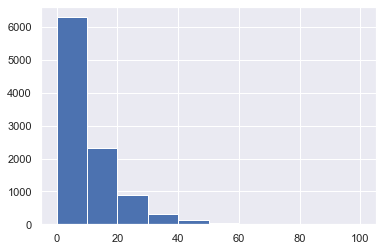

In [58]:
n4 = ex.rvs(size=10000,scale=scale,random_state=2017)
plt.hist(n4)
plt.show()

Si de la población se estudia una muestra de 10000 estudiantes, los resultados de las probabilidades es la siguiente:

$P(X\leq 10) = F(10)$

In [59]:
print(FDP(10,list(n4))-FDP(float('-inf'),list(n4)))

0.6289


$P(X = 20)$

In [60]:
print(fdp(20,list(n4)))

0.0


$P(X\geq 50) = 1 - F(50)$ 

In [61]:
print(1-FDP(50,list(n4)))

0.008299999999999974


_____________
**Análisis y Respuesta**

A medida que aumenta la cantidad de datos (**_n_**) las probabilidades empíricas se acercan a las probabilidades teórica. Por lo tanto, es posible decir que entre más grande es la muestra, más representativos son los resultados, en base a las características de la población. Además, a medida que aumenta la cantida de datos, es posible, mediante los histogramas, evidenciar de mejor manera la distribución exponencial y la concentración de datos entre los *0* minutos y *10* minutos.

A pesar de que los resultados empíricos se acercan a los teóricos a medida que aumenta el **_n_**, estos nunca serán *100%* acertivos, pues sólo son una representación de la población, y nunca se podrá representar a la población por completo. A no ser, por su puesto, que se estudie a la población y no a una muestra de ella.

___
>c) ¿Cuál debería ser la media **teórica** de todas estas distribuciones? ¿Y cuál es la empírica? ¿Si difieren o son iguales a qué se debe esto?


**R.-** Para obtener la media teórica se usan los métodos de la librería utilizada; Para obtener la media empírica para los distintos n dados se crea una función que cumpla el objetivo. 

Se calcula además el error porcentual de cada muestra para facilitar la comparación entre cada media empírica y la media teórica. El error porcentual sigue la siguiente fórmula:

$$Error\% = \frac{|ValorTeórico - ValorExperimental|}{ValorTeórico}\cdot 100$$

Desarrollo
-----------

**Media(list L)**

Función que recibe una lista de datos L y retorna la media aritmética de estos.

In [62]:
def Media(L):
    return sum(L)/len(L)

_________________
La media **teórica** de la distribuión exponencial con $\lambda = 0.1$ es igual a:

In [63]:
print(ex.mean(scale=scale))

10.0


______________
## Media Empírica

### n = 5

Media:

In [64]:
print(Media(list(n1)))

9.742151518900533


Error porcentual:

In [65]:
print(100*abs((ex.mean(scale=scale)-Media(n1))/ex.mean(scale=scale)))

2.57848481099467


____________
### n = 100

Media:

In [66]:
print(Media(list(n2)))

9.302970782804998


Error porcentual:

In [67]:
print(100*abs((ex.mean(scale=scale)-Media(n2))/ex.mean(scale=scale)))

6.970292171950021


________
### n = 300

Media:

In [68]:
print(Media(list(n3)))

9.214243231479177


Error porcentual:

In [69]:
print(100*abs((ex.mean(scale=scale)-Media(n3))/ex.mean(scale=scale)))

7.85756768520823


________
### n = 10000

Media:

In [70]:
print(Media(list(n4)))

10.099316350431872


Error porcentual:

In [71]:
print(100*abs((ex.mean(scale=scale)-Media(n4))/ex.mean(scale=scale)))

0.9931635043187192


______________
**Análisis y Respuesta**

Se evidencia una diferencia entre las 4 medias empíricas y el valor teórico, de las cuales la generada con _n = 10000_   presenta el menor error porcentual, de aproximadamente _0.993 %_. El mayor error lo presenta la distribución de _n = 300_ con un error porcentual aproximado de _7.858 %_

Esto se debe principalmente a la magnitud de la muestra, pues entre más cercana al $\infty$ es la cantidad de la muestra estudiada, más cerca se estará del valor teórico. Y al contrario, entre más cercana a $0$ sea el tamaño de la muestra, en general, más alejado se estará del valor teórico. En otra palabras, para un **_n_** cercano a $0$ no es probable obtener los resultados esperados, pero para un **_n_** cercano al $\infty$ es altamente probable obtener los valores teóricos.

______
>d) Genere **un** gráfico de 4 boxplot (1 de cada distribución) y compárelos. Comente lo que observa y concluya respecto a la ley de los grandes números.

Desarrollo
---------------

Boxplot generado con los datos utilizados anteriormente.

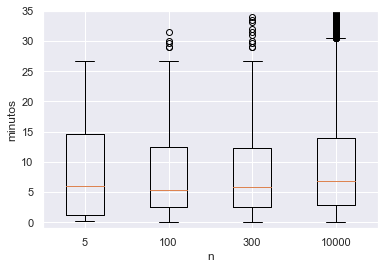

In [72]:
plt.boxplot([n1,n2,n3,n4],labels=['5','100','300','10000'])
plt.ylim(-1,35)
plt.xlabel('n')
plt.ylabel('minutos')
plt.show()

**Análisis y Respuesta**

Se aprecia, en el gráfico presentado, que el *50%* de los datos generados con un **_n_** igual 100, 300 y 10000 está contenido en el *50%* de los datos generadosu un un **_n_** igual a 5, indicando que esta ultima es mucho más dispersa que las demás, ya que su rango intercuartilico es mayor a los demás.

Los 4 boxplot presentan un sesgo positivo, lo que es característico en una distribución exponencial, indicando así, que los datos generados son una representación correcta de este tipo de distribución. Este sesgo es más evidente cuanto mayor es la cantidad de datos, pues a medida que aumenta el **_n_** hay más presencia de outliers sesgando aun más la muestra.

A pesar de la amplia diferencia, entre la cantidad de datos, de las 4 distribuciones generadas, todas presentan una mediana entre los *5* minutos y los *7* minutos, indicando que a pesar de la cantidad de datos esta caracterisitica on varía demasiado y que la mitad de los estudiantes no espeara más de *7* minutos en la fila del comedor. De igual forma, más del *75%* de los estudiantes, en las cuatro distribuciones, espera menos de *15* minutos en la fila.

En resumen, en consecuencia a lo encontrado empiricamente en los incisos anteriores y a lo estipulado teóricamente en el inciso _a)_, se comprueba la Ley de los Grandes Números, pues los resultados más cercanos a los teóricos son aquellos calculados con un **_n_** igual a 10000, el cual es el **_n_**, de los trabajados, más cercano a $\infty$. Esto nos sirve para obtener resultados acertados sin conocer los datos teóricos, basta con estudiar una muestra lo más cercana a $\infty$ posible y así aumentará la certidumbre de los calculos.